In [3]:
#Generic Python packages
import gc
import os
import numpy as np
import pandas as pd
#opening and dealing with files
import fitsio
#Coordinate systems
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy.wcs import WCS
#Big Beautiful Plots
import pylab as plt

# LSST Science Pipelines (Stack) Packages
from lsst.rsp import get_tap_service, retrieve_query

#for saving plots to my folder
my_path =  '/sdf/data/rubin/user/kexcel/plots'
#global plot parameters
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Loading in data

#### Q: TAP vs Butler?
For querying DP1 data, I'm using TAP. It's been recommended as the best way for searching on the catalog level. If you do choose to use the Butler, you'd define DP1 as the collection, and the quality flags would be added as columns to then be masked/restricted later. Here, with TAP, to mind the flags, you apply constraints on the query.

In [ ]:
#If using the Butler, this will be helpful:
#this is from RubinObs slack, Nacho Sevilla Noarbe sent it but it's maybe from Peter Ferguson and Douglas Tucker
#tract is a large section of the sky, made up of 10x10 patches
tract_dict={453: '47 Tuc',
            454: '47 Tuc',
           4849: 'ECDFS', #Euclid's "Euclid Deep Field Fornax" encompasses Extended Chandra Deep Field South
           5063: 'ECDFS',
           4848: 'ECDFS',
           2394: 'EDFS',
           2234: 'EDFS',
           4016: 'Fornax',
           4017: 'Fornax',
           4218: 'Fornax',
           4217: 'Fornax',
           5525: 'Rubin_SV_095-25',
           5526: 'Rubin_SV_095-25',
           7611: 'Seagull',
           7610: 'Seagull',
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7',
           10464: 'Rubin_SV_38_7',
           10704: 'Rubin_SV_38_7'
           }

In [4]:
service = get_tap_service("tap")
assert service is not None

In [5]:
def querylsst(service, query_cuts, ra, dec, radius=1.0):
    """ Return data queried from Rubin TAP

    Adapted from Kabelo Tsaine's simple_adl/query_TAP.py, edited to work on DP1 syntax

    Parameters
    ----------
    service: str
        TAP service
    ra: float
        Right Ascension [deg]
    dec: float
        Declination [deg]
    radius: float
        Radius around (ra, dec) [deg]

    Returns
    -------
    good_results: DataFrame
    """

    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg

    query = f"""
        SELECT
            coord_ra AS ra, coord_dec AS dec,
            g_extendedness, r_extendedness, i_extendedness, z_extendedness,
            g_SizeExtendedness, r_SizeExtendedness, i_SizeExtendedness, z_SizeExtendedness,
            g_psfFlux, r_psfFlux, i_psfFlux, z_psfFlux,
            g_psfFluxErr, r_psfFluxErr, i_psfFluxErr, z_psfFluxErr,
            g_cModelFlux, r_cModelFlux, i_cModelFlux, z_cModelFlux,
            g_cModelFluxErr, r_cModelFluxErr, i_cModelFluxErr, z_cModelFluxErr
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),
                        CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        """ + query_cuts

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    return results

In [6]:
#to offer the most flexibility in which cuts are applied, we construct it outside the function
query_cuts = ""

safe_max_extended = 1.0 #extendedness is supposed to be constructed cut off at 1.0
query_cuts += f"AND g_extendedness <= {str(safe_max_extended)} "
query_cuts +=  "AND detect_isIsolated = 1" #detect_isPrimary is already applied
for band in 'griz':
    #checking that each band has no flux flag
    query_cuts += f"AND {band}_psfFlux_flag = 0"

#I label what field is queried and what cuts have been applied up here
#so that the graph titles later on in the code have accurate labels
cuts = "all"
field = "EDFS" #coordinates for the center of ComCam/DP1 EDFS = 59.10, -48.73

lsst_query = querylsst(service, query_cuts, 59.10, -48.73, radius=2.0)
#I found it was simplest to apply SNR cuts like this
lsst_mask = (lsst_query['r_psfFlux'] / lsst_query['r_psfFluxErr']) > 5
lsst_field = lsst_query[lsst_mask]

#### Q: Where can I find Euclid data?
To the extent of my knowledge, as of 9/26/25, Euclid data has not been uploaded to NERSC. 
On USDF, there are 2 paths I know of:
- Peter Ferguson uploaded all Euclid q1 catalogs and the images (Y, J, H, and VIS) overlapping Euclid Deep Field South here: '/sdf/group/rubin/shared/euclid/'
    - I would just like to cite his notebook on working with Euclid data, I learned a lot from it
- Dan Taranu uploaded ECDFS Euclid VIS/NISP imaging here: '/sdf/data/rubin/user/dtaranu/tickets/cdfs/euclid/'

In [7]:
#coarser resolution to load in euclid files, which follow nside = 64 pixel name convention
nside = 64
lsst_ra = lsst_field['ra']
lsst_dec = lsst_field['dec']
#converting our queried LSST ra and dec into pixels
lsst_pix64 = hp.ang2pix(nside, lsst_ra, lsst_dec, lonlat=True, nest=True)
lsst_upix64 = np.unique(lsst_pix64.values)

euclid_path = "/sdf/group/rubin/shared/euclid/q1/catalogs/"
euclid = []
for pix in lsst_upix64:
    #iterating through the LSST pixels to see which Euclid files coarsely overlap
        #a finer resolution mask will be applied later
    euclid.append(fitsio.read(euclid_path + f"euclid_q1_mer_final_{pix:05d}.fits"))
euclid_fits = np.concatenate(euclid)

Euclid flags, explained in 'Euclid Quick Data Release (Q1), The active galaxies of Euclid' by Matamoro Zatarain et al. 2025:  
- "DET_QUALITY_FLAG values of 0, 2, and 512 indicate no problems with the data, sources blended together, 
and sources within an extended object area, respectively."
- <band>_FLAG = detect contamination in specific bands
- SPURIOUS_FLAG = detect contamination by spurious sources

In [8]:
#now get greater resolution to match up
NSIDE=4096
#get the pixels of LSST data
lsst_upix4096, lsst_cts = np.unique(hp.ang2pix(NSIDE, lsst_ra, lsst_dec, lonlat=True), return_counts=True)
#then get the pixels of Euclid data
euclid_pix4096 = hp.ang2pix(NSIDE, euclid_fits['RIGHT_ASCENSION'], euclid_fits['DECLINATION'], lonlat=True)
#Euclid has more coverage right now. We only keep the sources that lie in the LSST coverage
mask = np.isin(euclid_pix4096, lsst_upix4096) #[lsst_cts > 8])

#SNR cut
mask &= (euclid_fits['FLUX_VIS_PSF'] / euclid_fits['FLUXERR_VIS_PSF'] > 5)
#quality cuts defined above
mask &= (euclid_fits['SPURIOUS_FLAG'] == 0)
mask &= ((euclid_fits['DET_QUALITY_FLAG'] == 0) | (euclid_fits['DET_QUALITY_FLAG'] == 2) | (euclid_fits['DET_QUALITY_FLAG'] == 512))
for band in ['VIS', 'Y', 'J', 'H']:
    mask &= (euclid_fits[f'FLAG_{band}'] == 0)

euclid_field = euclid_fits[mask]
euclid_ra = euclid_field['RIGHT_ASCENSION']
euclid_dec = euclid_field['DECLINATION']

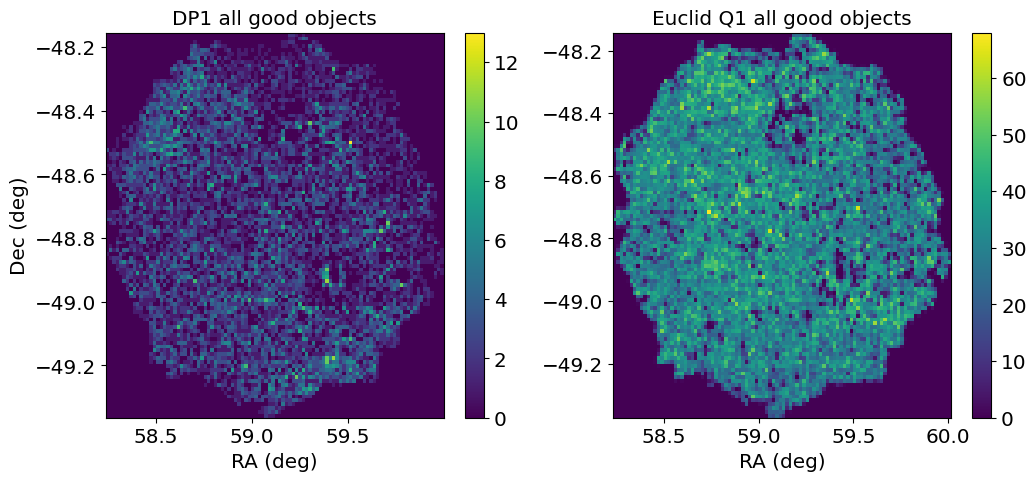

In [9]:
#Verify I matched up the fields correctly
fig, ax = plt.subplots(1,2, figsize=(12,5))

_, _, _, im = ax[0].hist2d(lsst_ra, lsst_dec, bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('DP1 all good objects')
ax[0].set_ylabel("Dec (deg)")
ax[0].set_xlabel("RA (deg)")

_, _, _, im = ax[1].hist2d(euclid_ra, euclid_dec, bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Euclid Q1 all good objects")
ax[1].set_xlabel("RA (deg)")
plt.savefig(my_path + f"/DP1_EUCLID_{field}maps_{cuts}mask.png")

#### Q: what are those artifacts? bright stars?
^I haven't answered that question for myself yet

Notes to self, **you can ignore**:
- it looks like the pixel matching is working well to not include euclid sources where comcam has blank artifacts
- artifacts present in plot with no mask, so is it a detector issue? bright foreground object?
    - comcam gets up to >100 sources in pixel w no mask
- even more splotchyness/artifacts when just a g_extendedness < 1 mask applied (what does that mask cut out?)
    - comcam cut down severely, get only to 50 sources in pixel
- detect_isIsolated big cut, takes it down to only max ~18 sources
- band flag mask only do a small cut (max ~16) and the SNR based on r band is a smaller cut too (max ~12)
- Euclid's SNR mask (at least, that mask being applied first) cuts it from 140 -> 80
- applying "euclid_fits['DET_QUALITY_FLAG'] == 0" gets this weird square in Euclid
    - oops! changing it to "(euclid_fits['DET_QUALITY_FLAG'] == 0) | (euclid_fits['DET_QUALITY_FLAG'] == 2) | (euclid_fits['DET_QUALITY_FLAG'] == 512)" fixes that

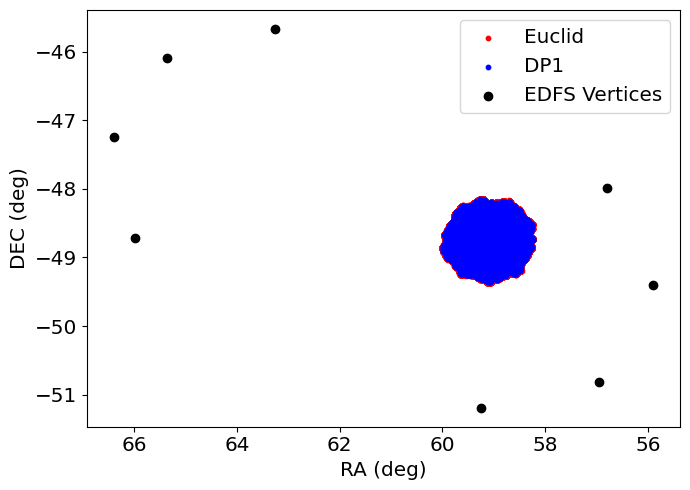

In [10]:
#Another coordinate mask verification
fig, ax = plt.subplots(1,1, figsize=(7,5))

#Define EDFS polygon region (vertices from Euclid documentation)
vertices = np.array([[63.25, -45.67], [65.35, -46.10], [66.40, -47.25],
       [65.99, -48.72], [59.25, -51.19], [56.95, -50.82],
       [55.90, -49.40], [56.80, -47.99]])

ax.scatter(euclid_ra, euclid_dec, s = 10, color='red', label = "Euclid")
ax.scatter(lsst_ra, lsst_dec, s = 10, color = 'blue', label = "DP1")
ax.set(xlabel = "RA (deg)", ylabel = "DEC (deg)")
ax.invert_xaxis()
euclid_center =  SkyCoord('04:04:57.84 -48:25:22.8', unit=(u.hourangle, u.deg), frame = 'icrs')
lsst_center = SkyCoord('59.10 -48.73', unit=(u.deg, u.deg), frame = 'icrs')
#plt.scatter(lsst_center.ra.deg, comcam_center.dec.deg, color = 'red', marker = '*', label = 'DP1 Center')
#plt.scatter(euclid_center.ra.deg, euclid_center.dec.deg, color = 'red', marker = '*', label = 'Euclid Center')
plt.scatter(vertices[:, 0], vertices[:, 1], color = 'k', label = 'EDFS Vertices')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.savefig(my_path + '/context_of_field')

Now, we're going to get a rough sketch of just the stars in each catalog. Euclid defines a "point like probability," which is a gradient from 0.0 to 1.0 where 1.0 is definitely a star and 0.0 definitely a galaxy. 'POINT_LIKE_PROB' is based on peak surface brightness vs integrated surface brightness.
DP1 defines "size extendedness" for each band. i seems to me to be the optimal choice here. (I have not found the documentation where 'SizeExtendedness' calculation is explained, but it's described as a "moments-based calculation")

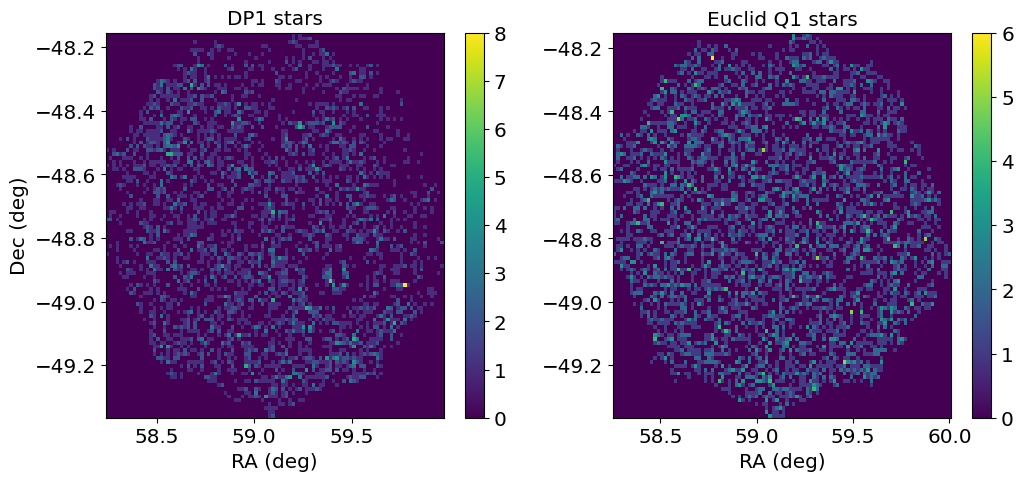

In [11]:
euclid_stars = euclid_field[euclid_field['POINT_LIKE_PROB'] > 0.7]
euclid_stars_ra = euclid_stars['RIGHT_ASCENSION']
euclid_stars_dec = euclid_stars['DECLINATION']

#one possible criterion
stardef = 'i_SizeExtendedness'
lsst_stars = lsst_field[lsst_field['i_SizeExtendedness'] < 0.5]
lsst_stars_ra = lsst_stars['ra']
lsst_stars_dec = lsst_stars['dec']

fig, ax = plt.subplots(1,2, figsize=(12,5))

_, _, _, im = ax[0].hist2d(lsst_stars_ra, lsst_stars_dec, bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set_title('DP1 stars')
ax[0].set_ylabel("Dec (deg)")
ax[0].set_xlabel("RA (deg)")

_, _, _, im = ax[1].hist2d(euclid_stars_ra, euclid_stars_dec, bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set_title("Euclid Q1 stars")
ax[1].set_xlabel("RA (deg)")
plt.savefig(my_path + f"/stars_DP1_EUCLID_{field}maps_basedon_{stardef}.png")

## Photometry

First! We'll just gain some intuition about what our catalogs' photometry look like. 
1) Graph some star galaxy separation plots (comparing cModel and PSF magnitudes) for each LSST band and then for Euclid's vis band
2) Graph color-mag for what LSST calls a star

#### Q: what's zero-point determined from? -> Rubin measures in nJy. AB system wants 0 mag to be ~ 3631 Jy which is $3.631 \times 10^{12} \rm{nJy}$ $$\\m = -2.5\log_{10}(f_v) + 2.5log_{10}(3.631 \times 10^{12}) = -2.5\log_{10}(f_v) + 31.4$$

#### Q: what's cmodel/physical meaning of psf - cmodel?
cModel = composite model. *insert more here*  

From DP0 documentation: "{band}_cModelFlux is a reasonable choice for galaxy fluxes. PSF model fluxes are generally recommended for point source photometry"
If the source is well fit by the psf flux (i.e. psf mag - cmodel mag is 0) it's point-like and likely a star. the worse it fits the psf model, the more extended it is (more likely to be a galaxy)

/tmp/ipykernel_2818/1342375618.py:3: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux) + zeropoint


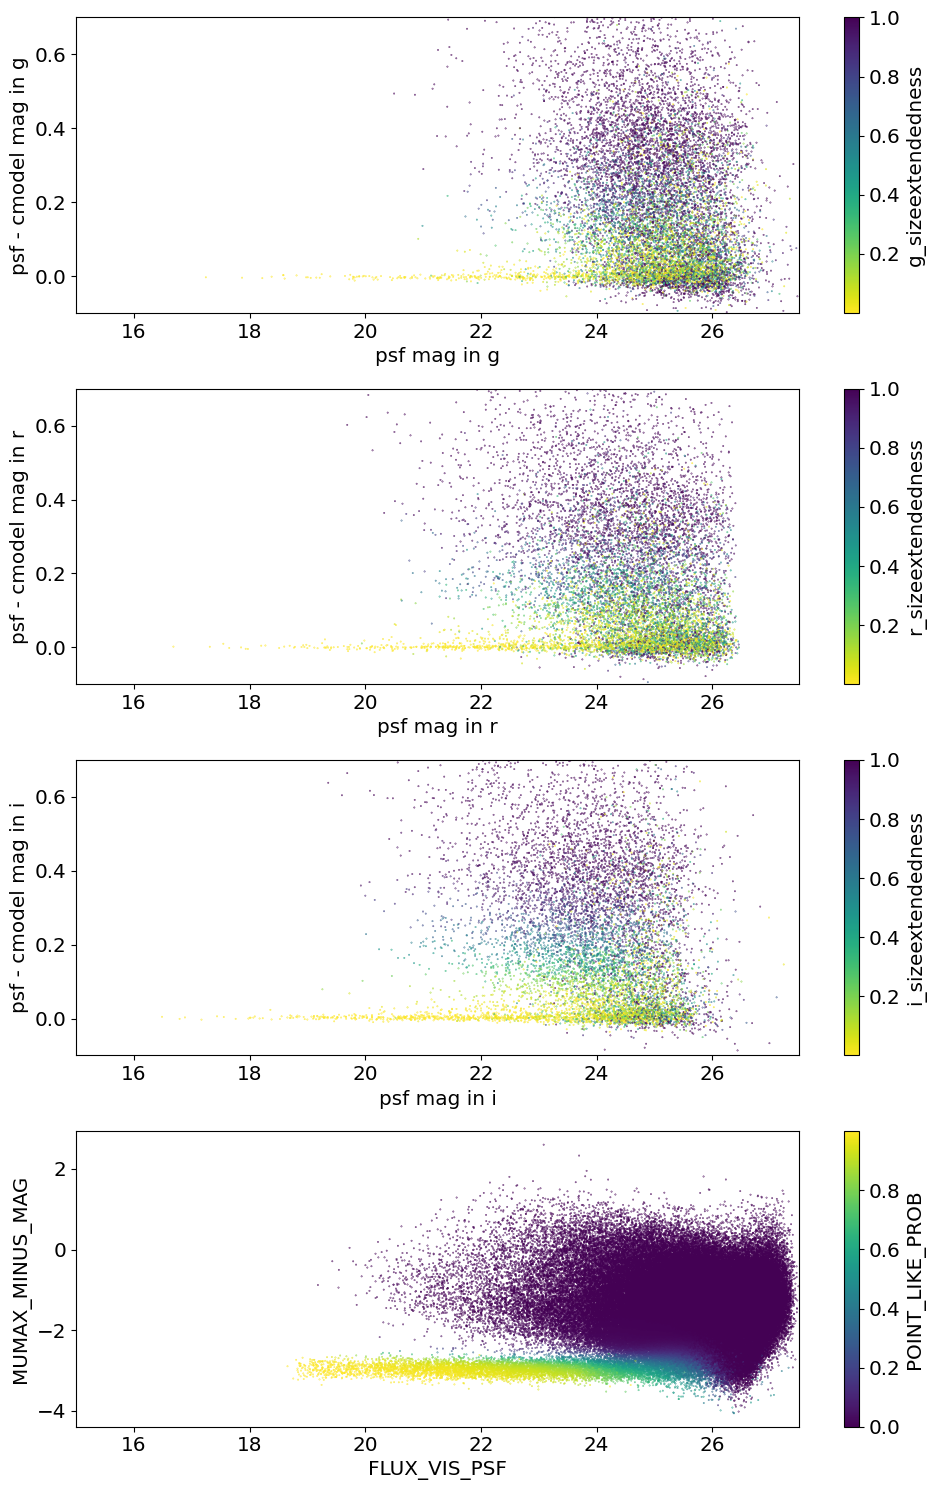

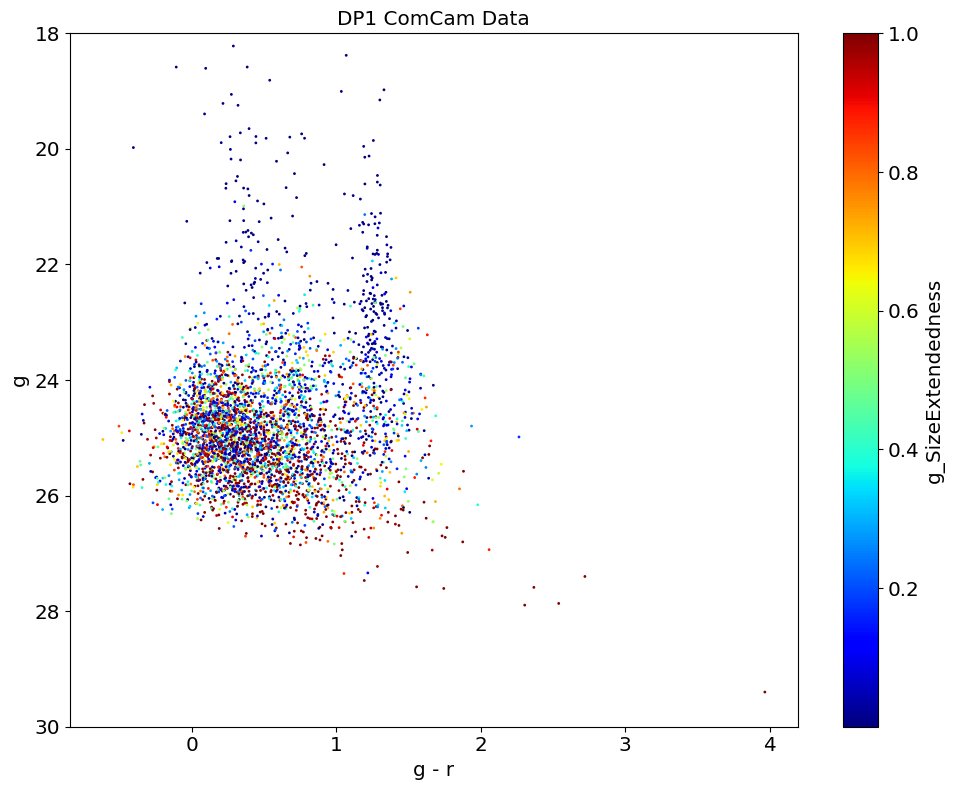

In [14]:
zeropoint = 31.4 # AB zero-point
def flux2mag(flux):
    return -2.5*np.log10(flux) + zeropoint


vis_mag = (euclid_field["FLUX_VIS_PSF"] * u.uJy).to(u.ABmag)

lsst_i_mag = flux2mag(lsst_field["i_psfFlux"].values)
lsst_i_mag_cmodel = flux2mag(lsst_field["i_cModelFlux"].values)
lsst_g_mag = flux2mag(lsst_field["g_psfFlux"].values)
lsst_g_mag_cmodel = flux2mag(lsst_field["g_cModelFlux"].values)
lsst_r_mag = flux2mag(lsst_field["r_psfFlux"].values)
lsst_r_mag_cmodel = flux2mag(lsst_field["r_cModelFlux"].values)

#PLOT 1: gaining intuition for what the separation looks like in each band
fig, ax = plt.subplots(4,1, figsize=(10,15))

_=ax[0].scatter(lsst_g_mag,
            lsst_g_mag - lsst_g_mag_cmodel,
            c=lsst_field["g_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="g_SizeExtendedness".lower())
ax[0].set(xlabel='psf mag in g', ylabel='psf - cmodel mag in g',
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[1].scatter(lsst_r_mag,
            lsst_r_mag - lsst_r_mag_cmodel,
            c=lsst_field["r_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="r_SizeExtendedness".lower())
ax[1].set(xlabel='psf mag in r', ylabel='psf - cmodel mag in r',
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[2].scatter(lsst_i_mag,
            lsst_i_mag - lsst_i_mag_cmodel,
            c=lsst_field["i_SizeExtendedness"],
            s=0.1, cmap="viridis_r")
plt.colorbar(_,label="i_SizeExtendedness".lower())
ax[2].set(xlabel='psf mag in i', ylabel='psf - cmodel mag in i',
          ylim=(-0.1,0.7), xlim=(15,27.5))

_=ax[3].scatter(vis_mag,
            euclid_field['MUMAX_MINUS_MAG'],
            c=euclid_field["POINT_LIKE_PROB"],
            s=0.1)
plt.colorbar(_,label="POINT_LIKE_PROB")
ax[3].set(xlabel='FLUX_VIS_PSF',
          ylabel='MUMAX_MINUS_MAG',
          xlim=(15,27.5))
plt.tight_layout()
plt.savefig(my_path + f"/photometry_attempt.png")

plt.show()

#PLOT 2: just LSST "stars" (based on i_SizeExtendedness) on color-mag diagram
fig, ax = plt.subplots(1,1, figsize=(10,8))

lsst_g_mag = flux2mag(lsst_stars["g_psfFlux"].values)
lsst_r_mag = flux2mag(lsst_stars["r_psfFlux"].values)

_=ax.scatter(lsst_g_mag - lsst_r_mag,
            lsst_g_mag,
            c=lsst_stars["i_SizeExtendedness"],
            s=1, cmap="jet")
plt.colorbar(_,label="i_SizeExtendedness")
ax.set(xlabel='g - r', ylabel='g',
          ylim = (30, 18), title='DP1 ComCam Data')
plt.tight_layout()
plt.savefig(my_path + f"/g_v_gminr.png")

Notes to self:
I seem to have a great number less of sources than Peter in his comcam plot. I don't think we have different cuts at all, except the g_extendedness < 1.0

## Match sources and merge catalogs

Our overall goal is to use Euclid to optimize Rubin's stellar population selection, so we need to match our sources. We can use astropy, but here I'm using ugali (tools created for DES by Alex Drlica-Wagner and Keith Bechtol et al.)

There is definitely a better way to import ugali tools, but can't install via pip here. My temporary workaround is to just copy and paste from their github https://github.com/DarkEnergySurvey/ugali

In [15]:
class SphericalRotator:
    """
    Base class for rotating points on a sphere.

    The input is a fiducial point (deg) which becomes (0, 0) in rotated coordinates.
    """

    def __init__(self, lon_ref, lat_ref, zenithal=False):
        self.setReference(lon_ref, lat_ref, zenithal)

    def setReference(self, lon_ref, lat_ref, zenithal=False):

        if zenithal:
            phi = (np.pi / 2.) + np.radians(lon_ref)
            theta = (np.pi / 2.) - np.radians(lat_ref)
            psi = 0.
        if not zenithal:
            phi = (-np.pi / 2.) + np.radians(lon_ref)
            theta = np.radians(lat_ref)
            # psi = 90 corresponds to (0, 0)
            # psi = -90 corresponds to (180, 0)
            psi = np.radians(90.)

        cos_psi,sin_psi = np.cos(psi),np.sin(psi)
        cos_phi,sin_phi = np.cos(phi),np.sin(phi)
        cos_theta,sin_theta = np.cos(theta),np.sin(theta)

        self.rotation_matrix = np.array([
            [cos_psi * cos_phi - cos_theta * sin_phi * sin_psi,
             cos_psi * sin_phi + cos_theta * cos_phi * sin_psi,
             sin_psi * sin_theta],
            [-sin_psi * cos_phi - cos_theta * sin_phi * cos_psi,
             -sin_psi * sin_phi + cos_theta * cos_phi * cos_psi,
             cos_psi * sin_theta],
            [sin_theta * sin_phi,
             -sin_theta * cos_phi,
             cos_theta]
        ])

        self.inverted_rotation_matrix = np.linalg.inv(self.rotation_matrix)

    def cartesian(self,lon,lat):
        lon = np.radians(lon)
        lat = np.radians(lat)

        x = np.cos(lat) * np.cos(lon)
        y = np.cos(lat) * np.sin(lon)
        z =  np.sin(lat)
        return np.array([x,y,z])

    def rotate(self, lon, lat, invert=False):
        vec = self.cartesian(lon,lat)

        if invert:
            vec_prime = np.dot(np.array(self.inverted_rotation_matrix), vec)
        else:
            vec_prime = np.dot(np.array(self.rotation_matrix), vec)

        lon_prime = np.arctan2(vec_prime[1], vec_prime[0])
        lat_prime = np.arcsin(vec_prime[2])

        return (np.degrees(lon_prime) % 360.), np.degrees(lat_prime)

def angsep(lon1,lat1,lon2,lat2):
    """
    Angular separation (deg) between two sky coordinates.
    Borrowed from astropy (www.astropy.org)

    Notes
    -----
    The angular separation is calculated using the Vincenty formula [1],
    which is slighly more complex and computationally expensive than
    some alternatives, but is stable at at all distances, including the
    poles and antipodes.

    [1] http://en.wikipedia.org/wiki/Great-circle_distance
    """
    lon1,lat1 = np.radians([lon1,lat1])
    lon2,lat2 = np.radians([lon2,lat2])

    sdlon = np.sin(lon2 - lon1)
    cdlon = np.cos(lon2 - lon1)
    slat1 = np.sin(lat1)
    slat2 = np.sin(lat2)
    clat1 = np.cos(lat1)
    clat2 = np.cos(lat2)

    num1 = clat2 * sdlon
    num2 = clat1 * slat2 - slat1 * clat2 * cdlon
    denominator = slat1 * slat2 + clat1 * clat2 * cdlon

    return np.degrees(np.arctan2(np.hypot(num1,num2), denominator))

def match(lon1, lat1, lon2, lat2, tol=None, nnearest=1):
    """
    Adapted from Eric Tollerud.
    Finds matches in one catalog to another.

    Parameters
    lon1 : array-like
        Longitude of the first catalog (degrees)
    lat1 : array-like
        Latitude of the first catalog (shape of array must match `lon1`)
    lon2 : array-like
        Longitude of the second catalog
    lat2 : array-like
        Latitude of the second catalog (shape of array must match `lon2`)
    tol : float or None, optional
        Proximity (degrees) of a match to count as a match.  If None,
        all nearest neighbors for the first catalog will be returned.
    nnearest : int, optional
        The nth neighbor to find.  E.g., 1 for the nearest nearby, 2 for the
        second nearest neighbor, etc.  Particularly useful if you want to get
        the nearest *non-self* neighbor of a catalog.  To do this, use:
        ``spherematch(lon, lat, lon, lat, nnearest=2)``

    Returns
    -------
    idx1 : int array
        Indices into the first catalog of the matches. Will never be
        larger than `lon1`/`lat1`.
    idx2 : int array
        Indices into the second catalog of the matches. Will never be
        larger than `lon2`/`lat2`.
    ds : float array
        Distance (in degrees) between the matches
    """
    from scipy.spatial import cKDTree

    lon1 = np.asarray(lon1)
    lat1 = np.asarray(lat1)
    lon2 = np.asarray(lon2)
    lat2 = np.asarray(lat2)

    if lon1.shape != lat1.shape:
        raise ValueError('lon1 and lat1 do not match!')
    if lon2.shape != lat2.shape:
        raise ValueError('lon2 and lat2 do not match!')

    rotator = SphericalRotator(0,0)


    # This is equivalent, but faster than just doing np.array([x1, y1, z1]).T
    x1, y1, z1 = rotator.cartesian(lon1.ravel(),lat1.ravel())
    coords1 = np.empty((x1.size, 3))
    coords1[:, 0] = x1
    coords1[:, 1] = y1
    coords1[:, 2] = z1

    x2, y2, z2 = rotator.cartesian(lon2.ravel(),lat2.ravel())
    coords2 = np.empty((x2.size, 3))
    coords2[:, 0] = x2
    coords2[:, 1] = y2
    coords2[:, 2] = z2

    tree = cKDTree(coords2)
    if nnearest == 1:
        idxs2 = tree.query(coords1)[1]
    elif nnearest > 1:
        idxs2 = tree.query(coords1, nnearest)[1][:, -1]
    else:
        raise ValueError('invalid nnearest ' + str(nnearest))

    ds = angsep(lon1, lat1, lon2[idxs2], lat2[idxs2])

    idxs1 = np.arange(lon1.size)

    if tol is not None:
        msk = ds < tol
        idxs1 = idxs1[msk]
        idxs2 = idxs2[msk]
        ds = ds[msk]

    return idxs1, idxs2, ds

10337 10337


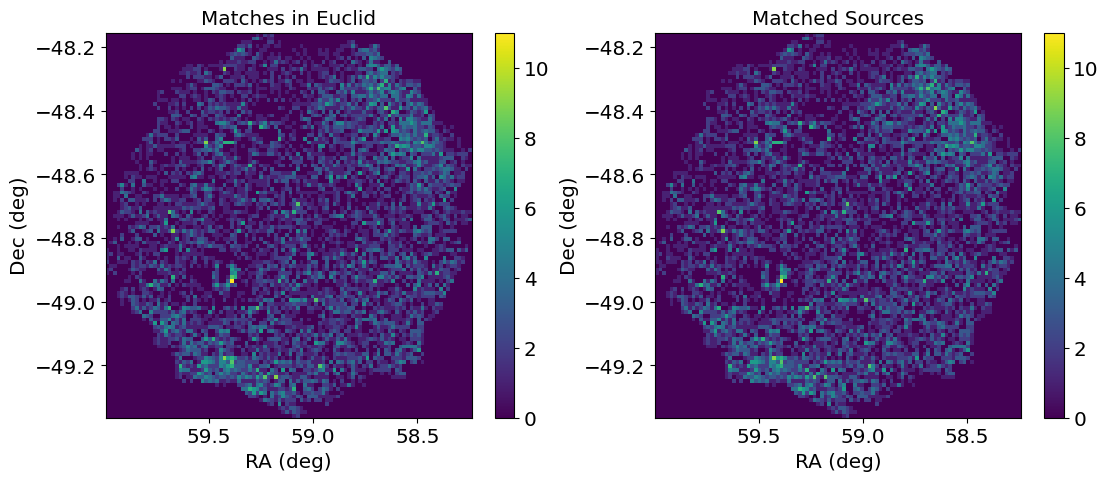

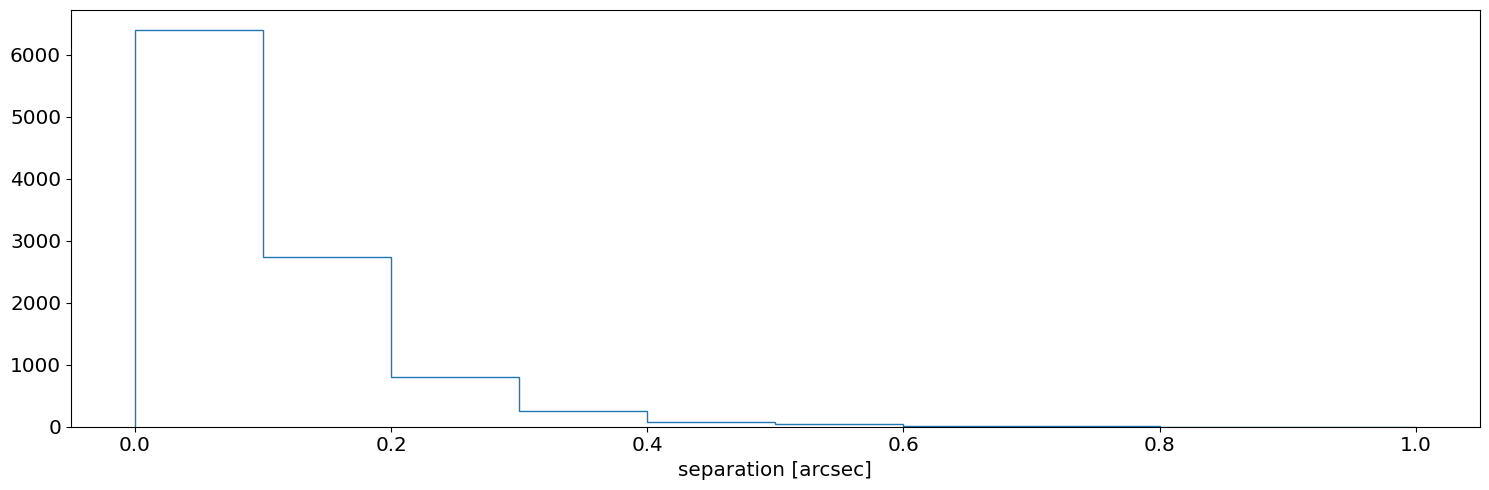

In [17]:
#use ugali tools to match LSST and Euclid sources
indexlsst, indexeuclid, ds = match(lsst_ra.values, lsst_dec.values, euclid_ra, euclid_dec, tol = 0.0003)

matches_lsst = lsst_field.to_numpy()[indexlsst]
matches_euclid = euclid_field[indexeuclid]
print(len(matches_lsst), len(matches_euclid))

#Match Verification
fig, ax = plt.subplots(1,2, figsize=(13,5))
_, _, _, im = ax[0].hist2d(matches_euclid['RIGHT_ASCENSION'], matches_euclid['DECLINATION'], bins=100)
plt.colorbar(im, ax=ax[0])
ax[0].set(title = 'Matches in Euclid', ylabel = "Dec (deg)", xlabel = "RA (deg)")
ax[0].invert_xaxis()
_, _, _, im = ax[1].hist2d(matches_lsst[:,0], matches_lsst[:,1], bins=100)
plt.colorbar(im, ax=ax[1])
ax[1].set(title = 'Matched Sources', ylabel = "Dec (deg)", xlabel = "RA (deg)")
ax[1].invert_xaxis()
plt.show()

ds = ds * 3600 #ds is in degrees, want to plot in arcsecs
#I forced in the function that matches would be <1"
plt.hist(ds, histtype='step', range=(0,1))
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()

14170


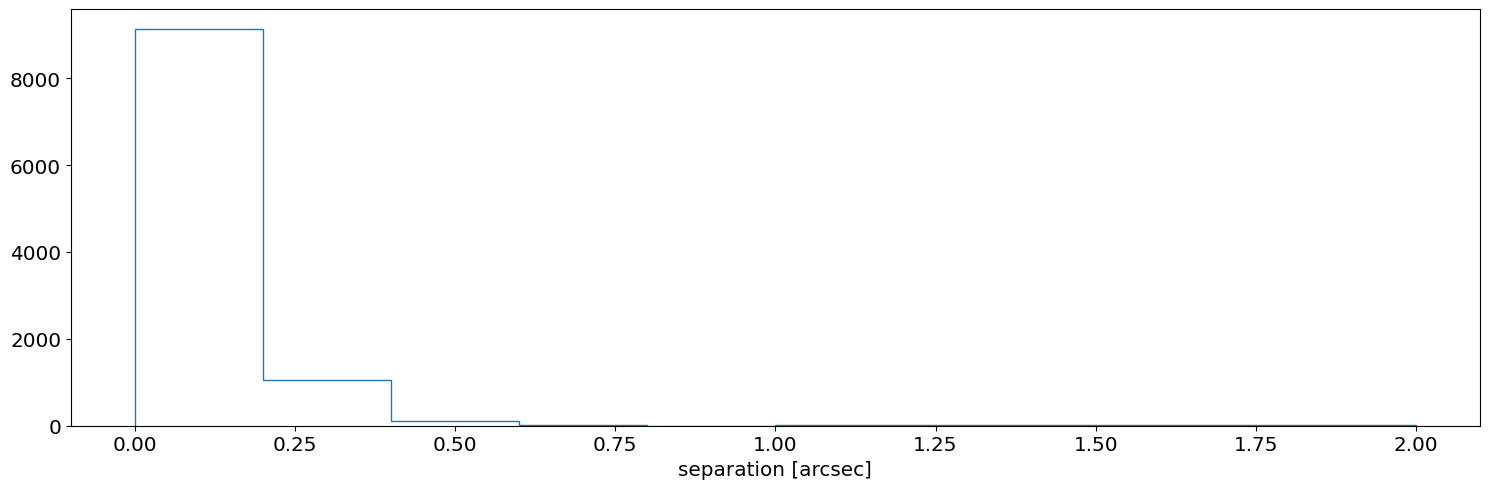

In [20]:
#here I was trying astropy and then deciding to go with ugali bc I couldn't figure out how to enforce a tolerance
lsstSkyCoord = SkyCoord(ra=lsst_ra.values*u.degree, dec=lsst_dec.values*u.degree, frame = 'icrs')
euclidSkyCoord = SkyCoord(ra=euclid_ra*u.degree, dec=euclid_dec*u.degree, frame = 'icrs')
index1, d2d1, d3d1 = lsstSkyCoord.match_to_catalog_sky(euclidSkyCoord)
#index = match index, d2d = distance apart on sky, d3d = 3D distance apart
matches1 = euclid_field[index1]
print(len(matches1))
plt.hist(d2d1.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()
plt.show()

In [32]:
#now merging our matches into one catalog with all LSST and Euclid columns
lsst_df = pd.DataFrame(matches_lsst, columns = lsst_field.columns)
euclid_df = pd.DataFrame(matches_euclid)
merged_df = lsst_df.join(euclid_df)
print(len(lsst_df), len(euclid_df), len(merged_df))

10337 10337 10337


All the dfs are the same length, as expected, but you might find the number of sources plotted when using columns such as POINT_LIKE_PROB or i_SizeExtendedness aren't the same, because some sources have NaN values for these columns

In [43]:
def color_magnitude(star_df, euc_colors, euc_label, lsst_colors, lsst_label, starselector_name, save = False, file_num = ''):
    '''
    Plots color-magnitude diagram, g vs g-r
    Expected that star_df would be sorted from a certain stellar classifier
        (i.e. just the sources LSST would classify as stars), but then those
        sources are plotted with both Euclid and LSST classifier colors

    Parameters
    ----------
    star_df : pandas dataframe
        Dataframe of the sources classified as stars
    euc_colors : dataframe column
        Data to be used for subplot 1 colorbar
        Euclid stellar classifier data (e.g. 'POINT_LIKE_PROB')
    euc_label : string
        Subplot 1 colorbar label
        Name of Euclid star classifier
    lsst_colors : dataframe column
        Data to be used for subplot 2 colorbar
        LSST-based stellar classifier data (e.g. 'i_SizeExtendedness')
    lsst_label : string
        Subplot 2 colorbar label
        Name of LSST star classifier
    starselector_name : string
        The survey with which the star_df has been sorted
        (e.g. if sorting based on 'i_SizeExtendedness' from DP1, this argument should be DP1)
    save (optional) : default False
        If True the file will be saved
    file_num (optional) : default ''
        You can optionally add a number if you don't want to overwrite
        the file previously saved with same name
        (file titles have form 'colormag_{starselector_name}stars_{lsst_label}_selector_{file_num}')

    Returns
    -------
    Pretty plot
    '''

    fig, ax = plt.subplots(1,2, figsize=(18,7))

    g_mag = flux2mag(star_df["g_psfFlux"].values)
    r_mag = flux2mag(star_df["r_psfFlux"].values)

    _ = ax[0].scatter(g_mag - r_mag, g_mag,
                c=lsst_colors,
                s=10, cmap="jet")
    cbar1 = plt.colorbar(_)#, ticks=[0.48, 0.4, 0.3, 0.2, 0.1, 0.02])
    cbar1.ax.invert_yaxis()
    #cbar1.ax.set_yticklabels(['more \n extended', '0.4', '0.3', '0.2', '0.1', 'less \n extended']) 
    cbar1.set_label(lsst_label)
    ax[0].set(xlabel='g - r', ylabel='g', xlim = (-1, 4), 
              ylim = (30, 18), title=f'{starselector_name}-Selected \'Stars\' Photometry with DP1 Extendedness')

    _ = ax[1].scatter(g_mag - r_mag, g_mag,
                c=euc_colors,
                s=10, cmap="jet_r")
    cbar2 = plt.colorbar(_) #, ticks=[0.02, 0.2, 0.4, 0.6, 0.8, 0.98])
    #cbar2.ax.set_yticklabels(['more \n extended', '0.2', '0.4', '0.6', '0.8', 'less \n extended'])
    cbar2.set_label(euc_label)
    ax[1].set(xlabel='g - r', ylabel='g', xlim = (-1, 4),
              ylim = (30, 18), title=f'{starselector_name}-Selected \'Stars\' Photometry with Euclid Extendedness')

    plt.tight_layout()
    if save == True:
        plt.savefig(my_path + f"/colormag_{starselector_name}stars_{lsst_label}_selector_{file_num}.png")



def color_color(star_df, euc_colors, euc_label, lsst_label, starselector_name, save = False, file_num = ''):
    '''
    Plots color-color, r-i vs g-r for different magnitudes
    Expected that star_df would be sorted from an LSST-based stellar classifier
        Point of this plot is to show how LSST's classification changes as sources get fainter

    Parameters
    ----------
    star_df : pandas dataframe
        Dataframe of the sources LSST classifies as stars
    euc_colors : dataframe column
        Data to be used for colorbar
        Euclid stellar classifier data (e.g. 'POINT_LIKE_PROB')
    euc_label : string
        Colorbar label
        Name of Euclid star classifier
    lsst_label : string
        Name of LSST star classifier used for star_df
        Only affects file name
    starselector_name : string
        The survey with which the star_df has been sorted
        (for now will just be DP1, just allowing for flexibility as more LSST data released)
    save (optional) : default False
        If True the file will be saved
    file_num (optional) : default ''
        You can optionally add a number if you don't want to overwrite
        the file previously saved with same name
        (file titles have form 'colorcolor_{starselector_name}stars_{lsst_label}_selector_{file_num}')

    Returns
    -------
    Pretty plot
    '''

    fig, ax = plt.subplots(1,3, figsize=(20,6))
    plt.suptitle(f'{starselector_name} \'Stars\' Photometry', fontsize = 18)

    g_mag = flux2mag(star_df["g_psfFlux"].values)
    r_mag = flux2mag(star_df["r_psfFlux"].values)
    i_mag = flux2mag(star_df["i_psfFlux"].values)

    bright = {"r mag" : [], "g mag" : [], "i mag" : [], "ext" : []}
    middle = {"r mag" : [], "g mag" : [], "i mag" : [], "ext" : []}
    dim = {"r mag" : [], "g mag" : [], "i mag" : [], "ext" : []}

    for i in range(len(r_mag)):
        r_i = r_mag[i]
        if (r_i > 18) and (r_i < 22):
            bright["r mag"].append(r_i)
            bright["g mag"].append(g_mag[i])
            bright["i mag"].append(i_mag[i])
            bright["ext"].append(euc_colors.to_list()[i])
        elif (r_i > 22) and (r_i < 24):
            middle["r mag"].append(r_i)
            middle["g mag"].append(g_mag[i])
            middle["i mag"].append(i_mag[i])
            middle["ext"].append(euc_colors.to_list()[i])
        else:
            dim["r mag"].append(r_i)
            dim["g mag"].append(g_mag[i])
            dim["i mag"].append(i_mag[i])
            dim["ext"].append(euc_colors.to_list()[i])
    for dic in [bright, middle, dim]:
        for key in dic.keys():
            dic[key] = np.array(dic[key])

    _ = ax[0].scatter(bright["g mag"] - bright["r mag"], bright["r mag"] - bright["i mag"],
                c=bright["ext"],
                s=15, cmap="jet_r")
    _ = ax[1].scatter(middle["g mag"] - middle["r mag"], middle["r mag"] - middle["i mag"],
                c=middle["ext"],
                s=15, cmap="jet_r")
    _ = ax[2].scatter(dim["g mag"] - dim["r mag"], dim["r mag"] - dim["i mag"],
                c=dim["ext"],
                s=15, cmap="jet_r")
    plt.colorbar(_,label=euc_label)
    ax[0].set(ylabel='r - i', ylim = (-0.6,2),
              xlabel='g - r', xlim = (-0.6,2.5),
              title='r mag 20 - 22')
    ax[1].set(ylabel='r - i', ylim = (-0.6,2),
              xlabel='g - r', xlim = (-0.6,2.5),
              title='r mag 22 - 24')
    ax[2].set(ylabel='r - i', ylim = (-0.6,2),
              xlabel='g - r', xlim = (-0.6,2.5),
              title='r mag 24 - 26')
    plt.tight_layout()
    if save == True:
        plt.savefig(my_path + f"/colorcolor_{starselector_name}stars_{lsst_label}_selector_{file_num}.png")


def star_gal_sep(merged_df, colors1, label1, colors2, label2, surveyname, y_bounds, save = False, file_num = ''):
    '''
    Plots color-color, r-i vs g-r for different magnitudes
    Expected that star_df would be sorted from an LSST-based stellar classifier
    Point of this plot is to show how LSST's classification changes as sources get fainter

    Parameters
    ----------
    merged_df : pandas dataframe
        Dataframe of all sources
    colors1 : dataframe column
        Data to be used for subplot 1 colorbar
    label1 : string
        Subplot 1 colorbar label
        If label1 and label2 are to be different, 
        label 1 should be the one for which you want the file named
    colors2 : dataframe column
        Data to be used for subplot 2 colorbar
    label2 : string
        Subplot 2 colorbar label
    surveyname : string
        Survey from which i band photometry is being pulled
        (where merged_df is getting its i_psfFlux and i_cModelFlux)
    y_bounds : tuple of floats
        Argument for subplot 1's ylim
        Found it necessary to zoom and enhance on LSST selector
    save (optional) : default False
        If True the file will be saved
    file_num (optional) : default ''
        You can optionally add a number if you don't want to overwrite
        the file previously saved with same name
        (file titles have form 'star-gal-sep_{label1}_selector_{file_num}')

    Returns
    -------
    Pretty plot
    '''

    fig, ax = plt.subplots(1,2, figsize=(18,6))

    i_mag = flux2mag(merged_df["i_psfFlux"].values)
    i_mag_cmodel = flux2mag(merged_df["i_cModelFlux"].values)

    _=ax[0].scatter(i_mag,
                i_mag - i_mag_cmodel,
                c = colors1,
                s = 10, cmap = "viridis_r")
    ax[0].set(xlabel = f'{surveyname} i_psfFlux', ylabel = f'{surveyname} i psf - cmodel mag', ylim = y_bounds)
    plt.colorbar(_,label = label1)
    _=ax[1].scatter(i_mag,
                merged_df['MUMAX_MINUS_MAG'],
                c = colors2,
                s = 10, cmap = 'viridis_r')
    plt.colorbar(_,label = label2)
    ax[1].set(xlabel = f'{surveyname} i_psfFlux', ylabel = "Euclid mu_max - mag")

    plt.tight_layout()
    if save == True:
        plt.savefig(my_path + f'/star-gal-sep_{label1}_selector_{file_num}.png')

#euclid-selected stars
euc_col = 'POINT_LIKE_PROB'
euc_label = "Euclid's POINT_LIKE_PROB"
euclid_star_df = merged_df[merged_df[euc_col]>0.5]
#lsst-selected stars
lsst_col = 'i_SizeExtendedness'
lsst_label = "DP1's i_SizeExtendedness"
lsst_star_df = merged_df[merged_df[lsst_col]<0.5]

Now that we have the infrastructure in place for plots, we can test some stellar classifiers to separate stars and galaxies. The star-galaxy separation plot can give you just a general idea if a classifier is promising or not. In an ideal world, the classifier would be such that the Euclid photometry subplot has all the galaxy cloud as one color and the star cloud as a different color.

I first tested out some combination of bands (more just as a proof that the code was working). They weren't super promising. Alex Drlica-Wagner in a set of slides suggested $(1-\rm{refFluxRatio})+\frac52\rm{refFluxRatioErr}$ as something that worked for DES.

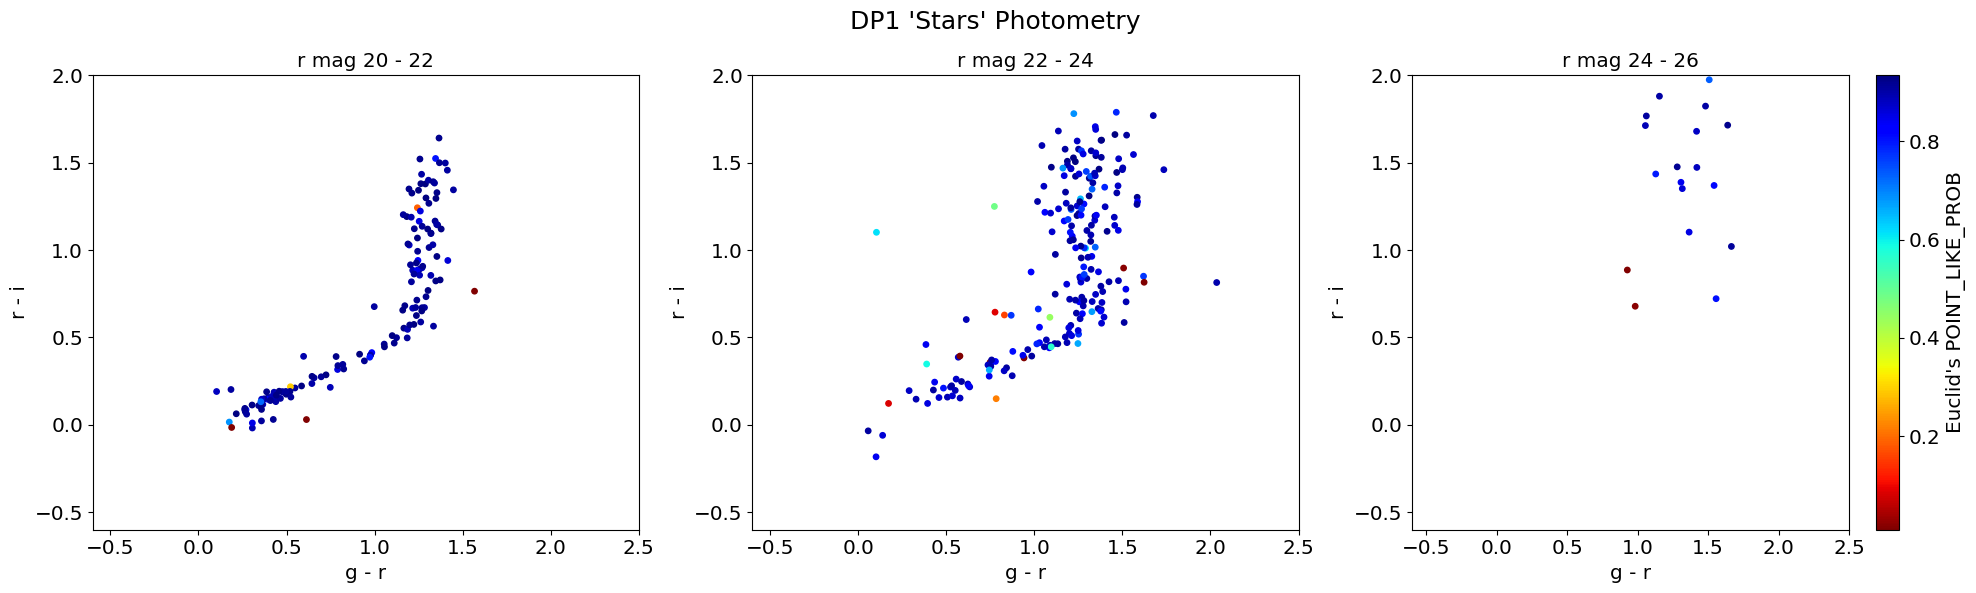

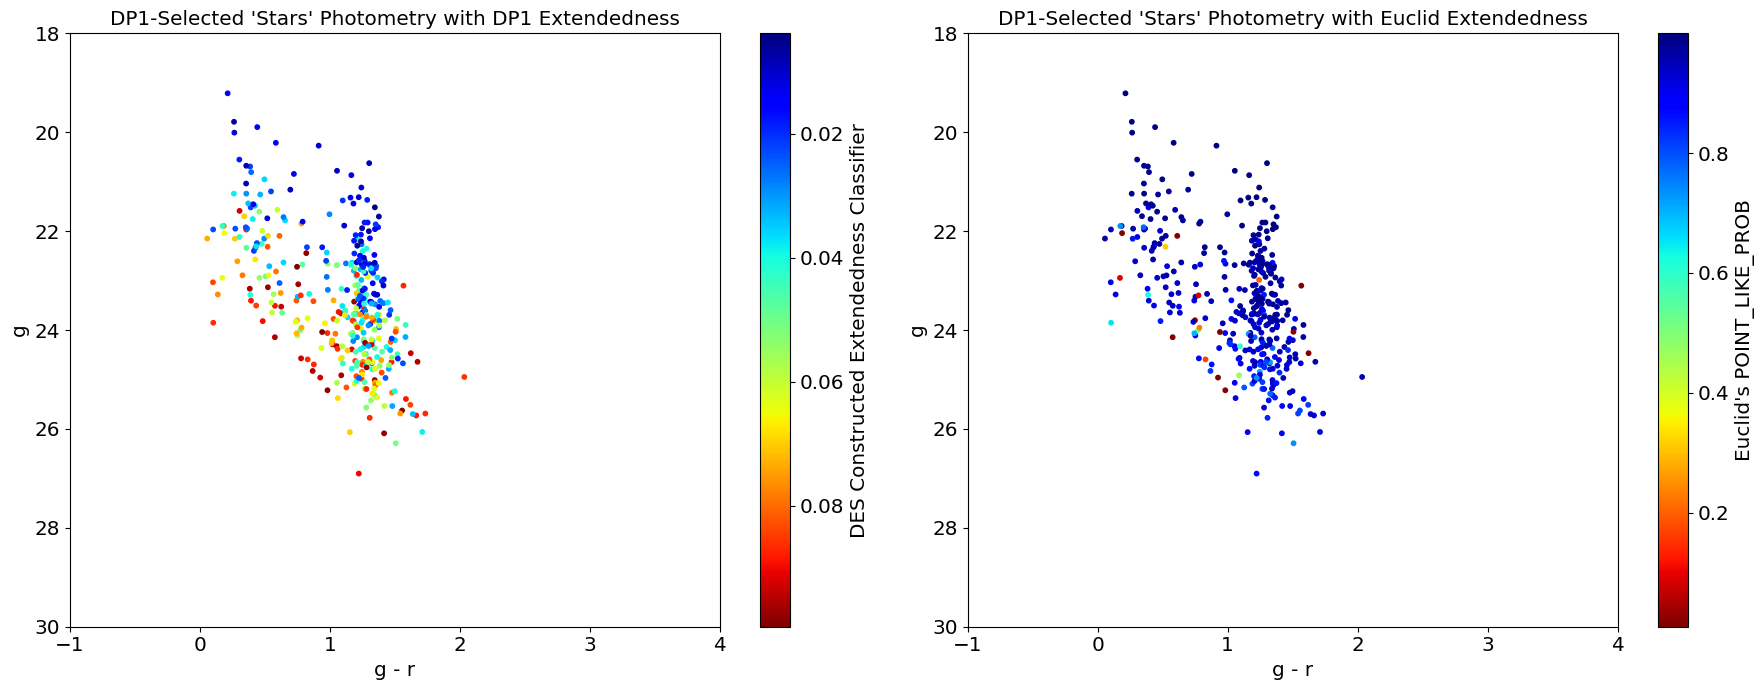

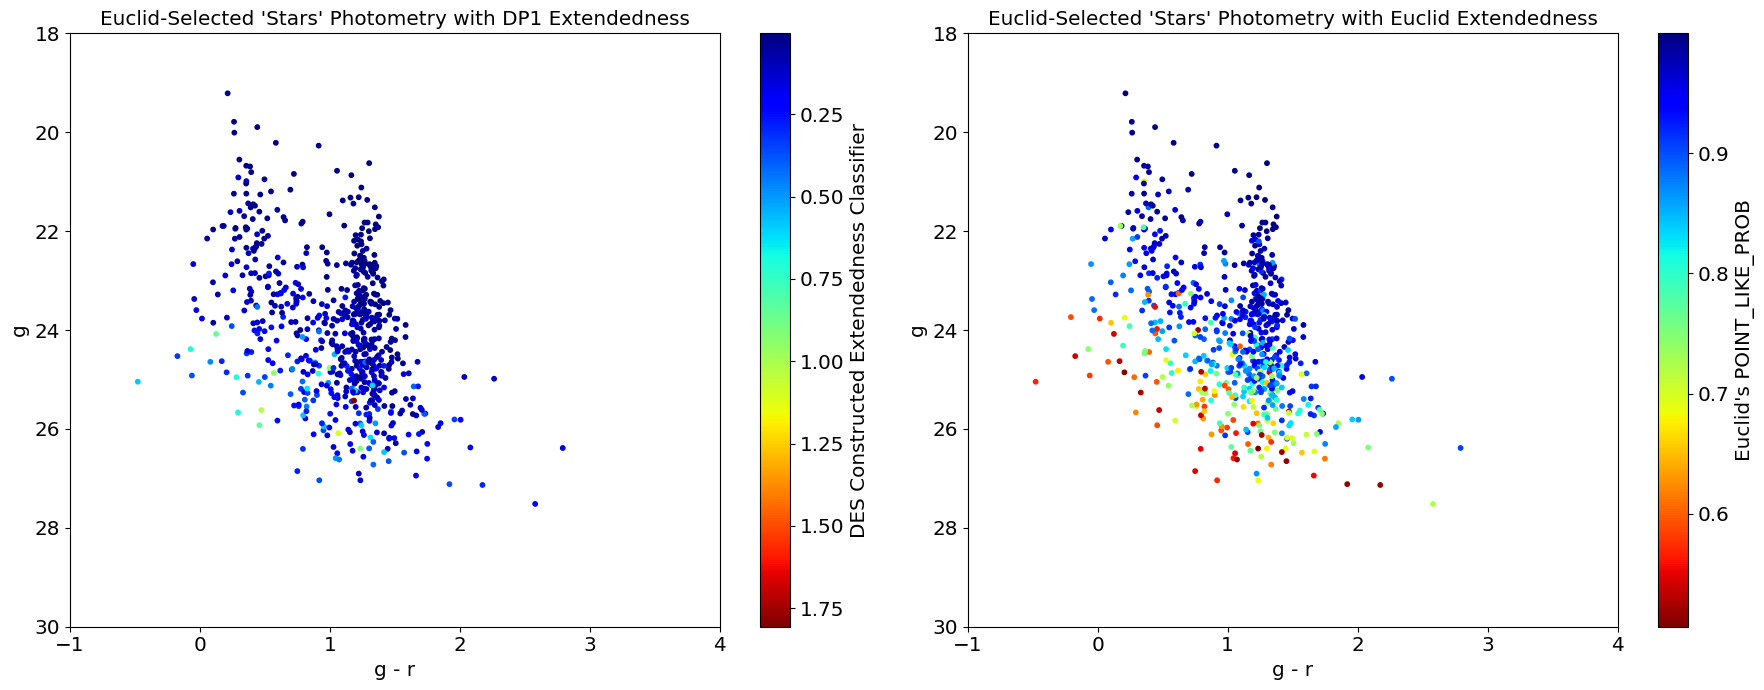

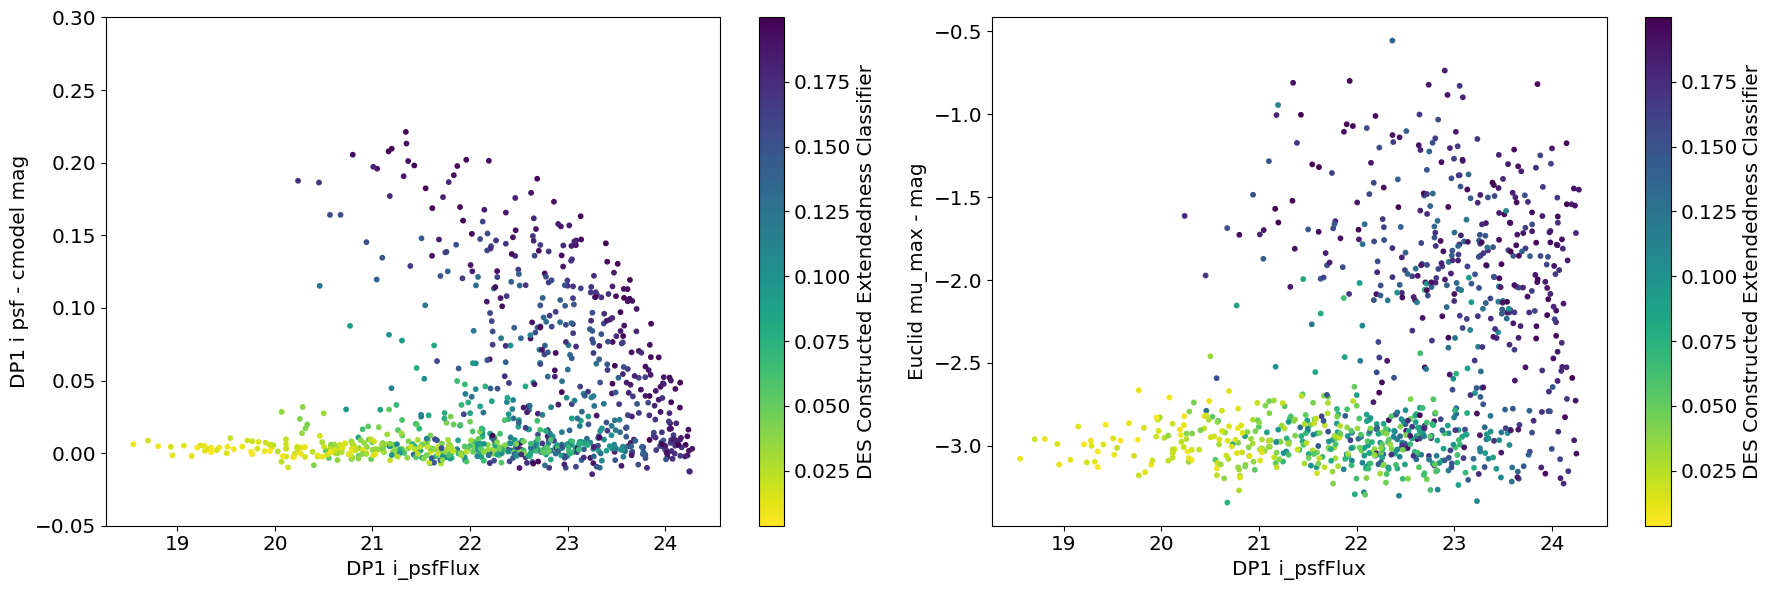

In [44]:
'''
CLASSIFIERS TRIED:
sqrt(g_ext^2 + r_ext^2 + i_ext^2), uhhh not good
(g_ext + r_ext + i_ext) / 3, also not good
(1 - i_flux_ratio) + (5/2)*i_flux_ratio_err, promising
'''
merged_df['SizeExtendedness Avg'] = (merged_df['g_SizeExtendedness'] + merged_df['r_SizeExtendedness'] + merged_df['i_SizeExtendedness'])/3
merged_df['|SizeExtendedness|'] = np.sqrt(merged_df['g_SizeExtendedness']**2 + merged_df['r_SizeExtendedness']**2 + merged_df['i_SizeExtendedness']**2)
i_flux_ratio = merged_df['i_psfFlux'] / merged_df['i_cModelFlux']
i_flux_ratio_err = np.sqrt((merged_df['i_psfFluxErr']/merged_df['i_cModelFlux'])**2 
                         + ((merged_df['i_psfFlux']/merged_df['i_cModelFlux']**2)*merged_df['i_cModelFluxErr'])**2)
merged_df['ext_class'] = (1 - i_flux_ratio) + (5/2)*i_flux_ratio_err

lsst_col2 = 'SizeExtendedness Avg'
lsst_label2 = "DP1's SizeExtendedness Average"
lsst_col3 = '|SizeExtendedness|'
lsst_label3 = "DP1's SizeExtendedness Inner Product"
lsst_col4 = 'ext_class'
lsst_label4 = "DES Constructed Extendedness Classifier"

#lsst-selected stars
lsst_star_df = merged_df[merged_df['ext_class']<0.1]

#euclid-selected stars
euc_col = 'POINT_LIKE_PROB'
euc_label = "Euclid's POINT_LIKE_PROB"
euclid_star_df = merged_df[merged_df[euc_col]>0.5]

color_color(lsst_star_df,
            lsst_star_df[euc_col], euc_label,
            lsst_label4, 'DP1',
            save = False, file_num = '')
color_magnitude(lsst_star_df,
                lsst_star_df[euc_col], euc_label,
                lsst_star_df[lsst_col4], lsst_label4,
                'DP1', save = True)
color_magnitude(euclid_star_df,
                euclid_star_df[euc_col], euc_label,
                euclid_star_df[lsst_col4], lsst_label4,
                'Euclid', save = True)
plt_df = merged_df[merged_df['ext_class']<0.2]
star_gal_sep(plt_df,
             plt_df[lsst_col4], lsst_label4,
             plt_df[lsst_col4], lsst_label4,
             'DP1', y_bounds = (-0.05, 0.3), save = True)

## Here be dragons (aka old code)

In [ ]:
##Learning hp package

NPIX = hp.nside2npix(NSIDE)

center_c = SkyCoord('04:04:57.84', '-48:25:22.8', unit=(u.hourangle, u.deg))
c_RA, c_DEC = center_c.ra.deg, center_c.dec.deg
center_pix = hp.ang2pix(NSIDE, c_RA, c_DEC, lonlat=True, nest=True)

#print(c_RA, c_DEC)

#print(f"NSIDE=64, Nest, HEALPix: {center_pix}")
print('center', center_pix)
vertices = np.array([[63.25, -45.67], [65.35, -46.10], [66.40, -47.25], 
       [65.99, -48.72], [59.25, -51.19], [56.95, -50.82], 
       [55.90, -49.40], [56.80, -47.99]])
#ang2pix(theta, phi)
vert_pix = hp.ang2pix(NSIDE, vertices[:,0], vertices[:,1], lonlat=True, nest=True)
print('vertices', vert_pix)


#ang2vec(lon, lat)
new_vert = hp.ang2vec(vertices[:,0], vertices[:,1], lonlat=True)
edfs = hp.query_polygon(NSIDE, new_vert, inclusive=True, nest=True)
print('field from query', edfs)


new_cen = hp.ang2vec(c_RA, c_DEC, lonlat=True)
circ = hp.query_disc(NSIDE, new_cen, np.radians(1), nest=True)
#print(circ)
m = np.arange(NPIX)
m[edfs] = m.max()
m[circ] = m.min()
hp.mollview(m, nest=True)

In [ ]:
"""
outside query
    config['data_dir'] = 'sdf/data/rubin/user/kexcel/software'     # dustmaps
    dustmaps.sfd.fetch()
    sfd = SFDQuery()
in query
    #Define E(B-V) at that position using SFD reddening maps
    R_g = 3.64
    R_r = 2.70
    R_i = 2.06

    E_BV = sfd(coord)

    A_g = R_g *E_BV
    A_r = R_r *E_BV
    A_i = R_i *E_BV
"""
#^ dustmap stuff, maybe add back in eventually
"""
# Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb
    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold =26 
"""
#^ doing this in a different way i think...
"""
can have this syntax: 
        #scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g,
        #scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r,
        #scisql_nanojanskyToAbMagSigma(g_cModelFlux, g_cModelFluxErr) AS magerr_g, 
        #scisql_nanojanskyToAbMagSigma(r_cModelFlux, r_cModelFluxErr) AS magerr_r,
        #scisql_nanojanskyToAbMag(g_cModelFlux) - {A_g} AS mag_corrected_g,     <-- dustmap stuff
        #scisql_nanojanskyToAbMag(r_cModelFlux) - {A_r} AS mag_corrected_r,
"""
#^but since I don't understand it, I'm leaving that out of the query

In [ ]:
## OLD CODE

'''
Rn I'm thinking the best way is to go pixel by pixel and cut the euclid data that doesn't align with the bounds of the comcam data,
but how to do that??
'''

'''
#gathering the pixels of all the comcam sources, making that a column in the dataframe
comcam_ra1 = raw_comcam1['coord_ra'] 
comcam_dec1 = raw_comcam1['coord_dec']
comcam_pix1 = hp.ang2pix(NSIDE, comcam_ra1, comcam_dec1, lonlat=True, nest=True)
raw_comcam1['hp pix'] = comcam_pix1

comcam_ra2 = raw_comcam2['coord_ra']
comcam_dec2 = raw_comcam2['coord_dec']
comcam_pix2 = hp.ang2pix(NSIDE, comcam_ra2, comcam_dec2, lonlat=True, nest=True)
raw_comcam2['hp pix'] = comcam_pix2

comcam1 = raw_comcam1.to_pandas()
comcam2 = raw_comcam2.to_pandas()
comcam_edfs_total = pd.concat([comcam1[comcam1['hp pix'].isin(list(edfs))], comcam2[comcam2['hp pix'].isin(list(edfs))]])

#combining the two tracts corresponding to comcam's edfs (this is *total*)
print(len(comcam_edfs_total))
type(comcam_edfs_total)
'''

'''
Look at tutorial DP02_03a_Image_Display_and_Manipulation when wanting to do images
Make a cutout rather than whole thing
'''